In [62]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import joblib

**Exploratory Data Analysis**

In [2]:
base_dir = "/kaggle/input/ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K"
training_dir = os.path.join(base_dir, 'Training Images')
testing_dir = os.path.join(base_dir, 'Testing Images')

# Count the number of images in each directory
def count_images(directory):
    count = 0
    for root, _, files in os.walk(directory):
        count += len([file for file in files if file.endswith('.jpg') or file.endswith('.png')])
    return count

# Get the counts for training and testing images
training_images_count = count_images(training_dir)
testing_images_count = count_images(testing_dir)

print(f"Number of images in Training Images directory: {training_images_count}")
print(f"Number of images in Testing Images directory: {testing_images_count}")


Number of images in Training Images directory: 7000
Number of images in Testing Images directory: 1000


In [3]:
# Define the paths for the files
data_xlsx_path = "/kaggle/input/ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K/data.xlsx"
full_df_csv_path = "/kaggle/input/ocular-disease-recognition-odir5k/full_df.csv"

# Load the Excel and CSV files
data_xlsx = pd.read_excel(data_xlsx_path)
full_df_csv = pd.read_csv(full_df_csv_path)

# Display the first few rows of each file
print("Preview of data.xlsx:")
print(data_xlsx.head())

print("\nPreview of full_df.csv:")
print(full_df_csv.head())

Preview of data.xlsx:
   ID  Patient Age Patient Sex Left-Fundus Right-Fundus  \
0   0           69      Female  0_left.jpg  0_right.jpg   
1   1           57        Male  1_left.jpg  1_right.jpg   
2   2           42        Male  2_left.jpg  2_right.jpg   
3   3           66        Male  3_left.jpg  3_right.jpg   
4   4           53        Male  4_left.jpg  4_right.jpg   

                            Left-Diagnostic Keywords  \
0                                           cataract   
1                                      normal fundus   
2  laser spot，moderate non proliferative retinopathy   
3                                      normal fundus   
4                        macular epiretinal membrane   

                Right-Diagnostic Keywords  N  D  G  C  A  H  M  O  
0                           normal fundus  0  0  0  1  0  0  0  0  
1                           normal fundus  1  0  0  0  0  0  0  0  
2  moderate non proliferative retinopathy  0  1  0  0  0  0  0  1  
3         bran

In [9]:
# Define the path for the preprocessed images directory
preprocessed_images_dir = "/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images"

# Check the contents of the preprocessed images folder
preprocessed_images_count = count_images(preprocessed_images_dir)
print(f"Number of images in Preprocessed Images directory: {preprocessed_images_count}")


Number of images in Preprocessed Images directory: 6392


**Data Preprocessing and Image Loading**

In [10]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.preprocessing import MultiLabelBinarizer
# Correcting the file paths in the dataframe
base_training_dir = "/kaggle/input/ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K/Training Images"
base_testing_dir = "/kaggle/input/ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K/Training Images"

# Update file paths for left and right fundus images
full_df_csv['filepath'] = full_df_csv.apply(
    lambda row: os.path.join(base_training_dir if os.path.exists(os.path.join(base_training_dir, row['Right-Fundus']))
                            else base_testing_dir, row['Right-Fundus']), axis=1)

# Display updated paths to verify
print(full_df_csv['filepath'].head())

# Apply the function to load a sample image to verify
sample_image_path = full_df_csv['filepath'][0]
sample_image = load_and_preprocess_image(sample_image_path)

# Show the shape of the sample image and its label
print(f"Sample image shape: {sample_image.shape}")


0    /kaggle/input/ocular-disease-recognition-odir5...
1    /kaggle/input/ocular-disease-recognition-odir5...
2    /kaggle/input/ocular-disease-recognition-odir5...
3    /kaggle/input/ocular-disease-recognition-odir5...
4    /kaggle/input/ocular-disease-recognition-odir5...
Name: filepath, dtype: object
Sample image shape: (224, 224, 3)


**Preparing the Data for Model Training**
* Separate the images and their corresponding labels.
* Encode the labels using multi-label binarization.
* Split the data into training and validation sets.

In [11]:
from sklearn.model_selection import train_test_split

# Define the labels (N, D, G, C, A, H, M, O) as columns for multi-label binarization
labels = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

# Binarize the labels using MultiLabelBinarizer
mlb = MultiLabelBinarizer(classes=labels)
full_df_csv['target'] = full_df_csv[labels].values.tolist()
full_df_csv['target'] = full_df_csv['target'].apply(lambda x: [i for i, val in enumerate(x) if val == 1])

# Get the images and labels
X = np.array([load_and_preprocess_image(filepath) for filepath in full_df_csv['filepath']])
y = mlb.fit_transform(full_df_csv['target'])

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Validation set shape: {X_val.shape}, {y_val.shape}")


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) [0, 1, 2, 3, 4, 5, 6, 7] will be ignored
  warnings.warn(


Training set shape: (5113, 224, 224, 3), (5113, 8)
Validation set shape: (1279, 224, 224, 3), (1279, 8)


In [12]:
# Correct the 'target' column by mapping numerical values to class names
def map_labels_to_classes(row, labels):
    return [label for label, value in zip(labels, row) if value == 1]

# Apply the mapping function to create a list of class names instead of numerical values
full_df_csv['target'] = full_df_csv[labels].apply(lambda row: map_labels_to_classes(row, labels), axis=1)

# Check the corrected 'target' column
print("\nCorrected 'target' column with class names:")
print(full_df_csv['target'].head())

# Apply MultiLabelBinarizer with the correct class names in 'target'
y = mlb.fit_transform(full_df_csv['target'])

# Check the transformed labels
print("\nTransformed 'y' labels after correcting the target column:")
print(y[:5])

# Check the classes learned by MultiLabelBinarizer
print("\nClasses in MultiLabelBinarizer after correction:")
print(mlb.classes_)

# Check if any rows in 'y' contain only zeros
all_zero_rows = np.all(y == 0, axis=1).sum()
print(f"\nNumber of rows in 'y' that contain only zeros after correction: {all_zero_rows}")

# Split the dataset into training and validation sets with corrected labels
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Check shapes and basic information
print(f"\nTraining set shape after correction: {X_train.shape}, {y_train.shape}")
print(f"Validation set shape after correction: {X_val.shape}, {y_val.shape}")

# Verify label distribution again after correction
print("\nLabel distribution in training set after correction:")
print(pd.DataFrame(y_train, columns=labels).sum())

print("\nLabel distribution in validation set after correction:")
print(pd.DataFrame(y_val, columns=labels).sum())


Corrected 'target' column with class names:
0       [C]
1       [N]
2    [D, O]
3    [D, O]
4       [D]
Name: target, dtype: object

Transformed 'y' labels after correcting the target column:
[[0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 1]
 [0 1 0 0 0 0 0 1]
 [0 1 0 0 0 0 0 0]]

Classes in MultiLabelBinarizer after correction:
['N' 'D' 'G' 'C' 'A' 'H' 'M' 'O']

Number of rows in 'y' that contain only zeros after correction: 0

Training set shape after correction: (5113, 224, 224, 3), (5113, 8)
Validation set shape after correction: (1279, 224, 224, 3), (1279, 8)

Label distribution in training set after correction:
N    1709
D    1677
G     313
C     320
A     260
H     158
M     239
O    1261
dtype: int64

Label distribution in validation set after correction:
N    392
D    446
G     84
C     82
A     59
H     45
M     67
O    327
dtype: int64


**Defining the CNN Model Architecture**

In [13]:
from tensorflow.keras import layers, models

# Define the CNN model architecture
def create_cnn_model(input_shape=(224, 224, 3)):
    model = models.Sequential()
    
    # Convolutional layers
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Flatten and dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))  # Adding dropout to prevent overfitting
    
    # Output layer with sigmoid activation for multi-label classification
    model.add(layers.Dense(8, activation='sigmoid'))  # 8 classes, one for each disease label
    
    # Compile the model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Create the model
cnn_model_corrected = create_cnn_model()

# Display the model summary
cnn_model_corrected.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,267,400 (73.50 MB)

 Trainable params: 19,267,400 (73.50 MB)

 Non-trainable params: 0 (0.00 B)

**Training the CNN Model**

In [14]:
# Training parameters
BATCH_SIZE = 32
EPOCHS = 20

# Train the model with the corrected labels
history_corrected = cnn_model_corrected.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/20


I0000 00:00:1727695154.494554     147 service.cc:145] XLA service 0x7a5f880040b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727695154.494623     147 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1727695154.494628     147 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  3/160 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.3021 - loss: 0.6167 

I0000 00:00:1727695161.995396     147 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


160/160 ━━━━━━━━━━━━━━━━━━━━ 38s 183ms/step - accuracy: 0.3231 - loss: 0.3970 - val_accuracy: 0.4003 - val_loss: 0.3579
Epoch 2/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.3602 - loss: 0.3552 - val_accuracy: 0.4277 - val_loss: 0.3464
Epoch 3/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.3719 - loss: 0.3481 - val_accuracy: 0.4230 - val_loss: 0.3389
Epoch 4/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.3825 - loss: 0.3438 - val_accuracy: 0.4480 - val_loss: 0.3328
Epoch 5/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.4378 - loss: 0.3318 - val_accuracy: 0.4550 - val_loss: 0.3283
Epoch 6/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.4220 - loss: 0.3285 - val_accuracy: 0.4441 - val_loss: 0.3291
Epoch 7/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.4327 - loss: 0.3234 - val_accuracy: 0.4605 - val_loss: 0.3164
Epoch 8/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.4390 - loss: 0.3179 - val_accuracy: 0.4

**Evaluating Model Performance**

In [15]:
from sklearn.metrics import classification_report, accuracy_score

# Make predictions on the validation set
y_val_pred = cnn_model_corrected.predict(X_val)

# Convert predictions to binary format (threshold of 0.5)
y_val_pred_binary = (y_val_pred > 0.5).astype(int)

# Calculate overall accuracy
overall_accuracy = accuracy_score(y_val, y_val_pred_binary)
print(f"Overall Accuracy: {overall_accuracy:.4f}")

# Generate a structured classification report for each label
report = classification_report(y_val, y_val_pred_binary, target_names=labels, output_dict=True)
print("\nClassification Report:")
print(report)

# Calculate and display precision, recall, and F1-score for each class label
print("\nDetailed metrics for each class label:")
for label in labels:
    label_precision = report[label]['precision']
    label_recall = report[label]['recall']
    label_f1 = report[label]['f1-score']
    print(f"Class {label}: Precision={label_precision:.4f}, Recall={label_recall:.4f}, F1-Score={label_f1:.4f}")


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Overall Accuracy: 0.7310

Classification Report:
{'N': {'precision': 0.8159203980099502, 'recall': 0.8367346938775511, 'f1-score': 0.8261964735516372, 'support': 392}, 'D': {'precision': 0.8992248062015504, 'recall': 0.7802690582959642, 'f1-score': 0.8355342136854742, 'support': 446}, 'G': {'precision': 0.8955223880597015, 'recall': 0.7142857142857143, 'f1-score': 0.7947019867549668, 'support': 84}, 'C': {'precision': 0.9393939393939394, 'recall': 0.7560975609756098, 'f1-score': 0.8378378378378378, 'support': 82}, 'A': {'precision': 0.9555555555555556, 'recall': 0.7288135593220338, 'f1-score': 0.8269230769230769, 'support': 59}, 'H': {'precision': 0.9428571428571428, 'recall': 0.7333333333333333, 'f1-score': 0.8250000000000001, 'support': 45}, 'M': {'precision': 0.9836065573770492, 'recall': 0.8955223880597015, 'f1-score': 0.9375, 'support': 67}, 'O': {'precision': 0.8781512605042017, 'recall': 0.6391437308868502, 'f1-score': 0.7398230088495575, 

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Extract Features Using the CNN Model**

In [16]:
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model

# Define a new CNN model using the functional API
input_tensor = Input(shape=(224, 224, 3))

# Convolutional layers
x = Conv2D(32, (3, 3), activation='relu')(input_tensor)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(256, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

# Flatten and dense layers
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)

# Output layer
output_tensor = Dense(8, activation='sigmoid')(x)

# Create the functional model
cnn_feature_extractor = Model(inputs=input_tensor, outputs=output_tensor)

# Print the summary of the newly created feature extractor model
cnn_feature_extractor.summary()


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,267,400 (73.50 MB)

 Trainable params: 19,267,400 (73.50 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Extract features from the training and validation sets using the new feature extractor model
X_train_features = cnn_feature_extractor.predict(X_train)
X_val_features = cnn_feature_extractor.predict(X_val)

# Display the shape of the extracted features to confirm
print(f"Shape of training features: {X_train_features.shape}")
print(f"Shape of validation features: {X_val_features.shape}")


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Shape of training features: (5113, 8)
Shape of validation features: (1279, 8)


In [18]:
import numpy as np

# Convert multi-label format to single-label by choosing the label with the highest value
y_train_single_label = np.argmax(y_train, axis=1)
y_val_single_label = np.argmax(y_val, axis=1)

print(f"Shape of transformed training labels: {y_train_single_label.shape}")
print(f"Shape of transformed validation labels: {y_val_single_label.shape}")


Shape of transformed training labels: (5113,)
Shape of transformed validation labels: (1279,)


In [22]:
from sklearn import svm
from sklearn.metrics import classification_report, accuracy_score

# Define the SVM model
svm_classifier = svm.SVC(kernel='linear', probability=True)

# Train the SVM classifier on the extracted features using the transformed labels
svm_classifier.fit(X_train_features, y_train_single_label)

# Make predictions on the validation set
y_val_pred_svm = svm_classifier.predict(X_val_features)

# Calculate accuracy and generate a classification report for the SVM predictions
svm_accuracy = accuracy_score(y_val_single_label, y_val_pred_svm)
print(f"SVM Model Accuracy: {svm_accuracy:.4f}")

# Generate a classification report for the SVM predictions
svm_report = classification_report(y_val_single_label, y_val_pred_svm, target_names=labels)
print("\nSVM Classification Report:")
print(svm_report)


SVM Model Accuracy: 0.3065

SVM Classification Report:
              precision    recall  f1-score   support

           N       0.31      1.00      0.47       392
           D       0.00      0.00      0.00       446
           G       0.00      0.00      0.00        76
           C       0.00      0.00      0.00        67
           A       0.00      0.00      0.00        44
           H       0.00      0.00      0.00        19
           M       0.00      0.00      0.00        58
           O       0.00      0.00      0.00       177

    accuracy                           0.31      1279
   macro avg       0.04      0.12      0.06      1279
weighted avg       0.09      0.31      0.14      1279



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Define base learners
base_learners = [
    ('svm', svm.SVC(kernel='linear', probability=True)),
]

# Define the meta-learner (Logistic Regression)
meta_learner = LogisticRegression()

# Create the stacking ensemble model
stacking_model = StackingClassifier(estimators=base_learners, final_estimator=meta_learner)

# Train the stacking model using the features extracted from CNN
stacking_model.fit(X_train_features, y_train_single_label)

# Make predictions on the validation set using the stacking model
y_val_pred_stacking = stacking_model.predict(X_val_features)

# Calculate accuracy for the stacking model
stacking_accuracy = accuracy_score(y_val_single_label, y_val_pred_stacking)
print(f"Stacking Model Accuracy: {stacking_accuracy:.4f}")

# Generate a classification report for the stacking model predictions
stacking_report = classification_report(y_val_single_label, y_val_pred_stacking, target_names=labels)
print("\nStacking Model Classification Report:")
print(stacking_report)


Stacking Model Accuracy: 0.3651

Stacking Model Classification Report:
              precision    recall  f1-score   support

           N       0.33      0.85      0.48       392
           D       0.48      0.29      0.36       446
           G       0.00      0.00      0.00        76
           C       0.00      0.00      0.00        67
           A       0.00      0.00      0.00        44
           H       0.00      0.00      0.00        19
           M       0.45      0.09      0.14        58
           O       0.00      0.00      0.00       177

    accuracy                           0.37      1279
   macro avg       0.16      0.15      0.12      1279
weighted avg       0.29      0.37      0.28      1279



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Define additional base learners
base_learners = [
    ('svm', svm.SVC(kernel='linear', probability=True)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=5))
]

# Create a new stacking ensemble model with multiple base learners
stacking_model_adv = StackingClassifier(estimators=base_learners, final_estimator=LogisticRegression())

# Train the advanced stacking model using the features extracted from CNN
stacking_model_adv.fit(X_train_features, y_train_single_label)

# Make predictions on the validation set using the advanced stacking model
y_val_pred_stacking_adv = stacking_model_adv.predict(X_val_features)

# Calculate accuracy for the advanced stacking model
stacking_accuracy_adv = accuracy_score(y_val_single_label, y_val_pred_stacking_adv)
print(f"Advanced Stacking Model Accuracy: {stacking_accuracy_adv:.4f}")

# Generate a classification report for the advanced stacking model predictions
stacking_report_adv = classification_report(y_val_single_label, y_val_pred_stacking_adv, target_names=labels)
print("\nAdvanced Stacking Model Classification Report:")
print(stacking_report_adv)


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Advanced Stacking Model Accuracy: 0.8499

Advanced Stacking Model Classification Report:
              precision    recall  f1-score   support

           N       0.80      0.91      0.85       392
           D       0.83      0.87      0.85       446
           G       0.98      0.72      0.83        76
           C       0.94      0.76      0.84        67
           A       0.97      0.82      0.89        44
           H       1.00      0.84      0.91        19
           M       0.92      0.83      0.87        58
           O       0.91      0.76      0.83       177

    accuracy                           0.85      1279
   macro avg       0.92      0.81      0.86      1279
weighted avg       0.86      0.85      0.85      1279



In [38]:
# Print shapes and data types to check consistency
print(f"Shape of y_val_single_label: {y_val_single_label.shape}, Type: {type(y_val_single_label)}")
print(f"Shape of y_val_pred_binary: {y_val_pred_binary.shape}, Type: {type(y_val_pred_binary)}")

# Check if both true labels and predictions have consistent formats
print(f"Unique values in y_val_single_label: {np.unique(y_val_single_label)}")
print(f"Unique values in y_val_pred_binary: {np.unique(y_val_pred_binary)}")

# Print an example of both for a better understanding
print(f"Example from y_val_single_label:\n{y_val_single_label[:5]}")
print(f"Example from y_val_pred_binary:\n{y_val_pred_binary[:5]}")


Shape of y_val_single_label: (1279, 8), Type: <class 'numpy.ndarray'>
Shape of y_val_pred_binary: (1279,), Type: <class 'numpy.ndarray'>
Unique values in y_val_single_label: [0. 1.]
Unique values in y_val_pred_binary: [0 1]
Example from y_val_single_label:
[[0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
Example from y_val_pred_binary:
[1 0 0 0 1]


In [39]:
# Make sure y_val_pred_binary is a 2D binary array matching the shape of y_val_single_label
# Adjusting the shape if needed
if len(y_val_pred_binary.shape) == 1:
    y_val_pred_binary = np.expand_dims(y_val_pred_binary, axis=1)  # Expand dimensions to make it 2D
    y_val_pred_binary = np.repeat(y_val_pred_binary, y_val_single_label.shape[1], axis=1)  # Repeat for each label

# Check the new shape of y_val_pred_binary after adjustment
print(f"Adjusted Shape of y_val_pred_binary: {y_val_pred_binary.shape}")

# Now both y_val_single_label and y_val_pred_binary should have the same shape
# Calculate accuracy for the adjusted multi-label binary predictions
stacking_accuracy_pca = accuracy_score(y_val_single_label, y_val_pred_binary)
print(f"Stacking Model with PCA Accuracy: {stacking_accuracy_pca:.4f}")

# Generate and print the classification report for multi-label predictions
stacking_report_pca = classification_report(y_val_single_label, y_val_pred_binary, target_names=labels)
print("\nStacking Model with PCA Classification Report after Adjustments:")
print(stacking_report_pca)


Adjusted Shape of y_val_pred_binary: (1279, 8)
Stacking Model with PCA Accuracy: 0.0000

Stacking Model with PCA Classification Report after Adjustments:
              precision    recall  f1-score   support

           N       0.04      0.09      0.06       392
           D       0.48      0.89      0.62       446
           G       0.08      0.89      0.15        76
           C       0.08      0.96      0.14        67
           A       0.05      0.86      0.09        44
           H       0.02      1.00      0.04        19
           M       0.06      0.86      0.11        58
           O       0.19      0.91      0.32       177

   micro avg       0.12      0.65      0.21      1279
   macro avg       0.12      0.81      0.19      1279
weighted avg       0.22      0.65      0.30      1279
 samples avg       0.08      0.65      0.14      1279



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
from sklearn.preprocessing import MultiLabelBinarizer

# Define thresholds for each class (you can experiment with these values)
class_thresholds = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]  # Modify these as needed

# Apply threshold tuning to each class separately
y_val_pred_binary_tuned = np.zeros_like(y_val_pred_prob_adv)

# Iterate through each class and apply the threshold
for i in range(y_val_pred_prob_adv.shape[1]):
    y_val_pred_binary_tuned[:, i] = (y_val_pred_prob_adv[:, i] >= class_thresholds[i]).astype(int)

# Check the shape and unique values of y_val_pred_binary_tuned
print(f"Shape of y_val_pred_binary_tuned: {y_val_pred_binary_tuned.shape}")
print(f"Unique values in y_val_pred_binary_tuned: {np.unique(y_val_pred_binary_tuned)}")

# Calculate accuracy for the tuned binary predictions
stacking_accuracy_tuned = accuracy_score(y_val_single_label, y_val_pred_binary_tuned)
print(f"Stacking Model with PCA Accuracy after Threshold Tuning: {stacking_accuracy_tuned:.4f}")

# Generate and print the classification report for multi-label predictions
stacking_report_tuned = classification_report(y_val_single_label, y_val_pred_binary_tuned, target_names=labels)
print("\nStacking Model with PCA Classification Report after Threshold Tuning:")
print(stacking_report_tuned)


Shape of y_val_pred_binary_tuned: (1279, 8)
Unique values in y_val_pred_binary_tuned: [0. 1.]
Stacking Model with PCA Accuracy after Threshold Tuning: 0.8038

Stacking Model with PCA Classification Report after Threshold Tuning:
              precision    recall  f1-score   support

           N       0.90      0.87      0.88       392
           D       0.92      0.79      0.85       446
           G       1.00      0.72      0.84        76
           C       1.00      0.76      0.86        67
           A       1.00      0.82      0.90        44
           H       1.00      0.84      0.91        19
           M       0.96      0.76      0.85        58
           O       0.97      0.75      0.85       177

   micro avg       0.93      0.80      0.86      1279
   macro avg       0.97      0.79      0.87      1279
weighted avg       0.94      0.80      0.86      1279
 samples avg       0.80      0.80      0.80      1279



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [49]:
# Assuming y_train and y_val are the original labels from your dataset before any transformation
print("Original y_train labels shape:", y_train.shape)
print("Original y_val labels shape:", y_val.shape)
print("Example entries from original y_train:", y_train[:10])
print("Example entries from original y_val:", y_val[:10])

# Check if y_train and y_val contain valid class labels
unique_train_labels = np.unique(y_train)
unique_val_labels = np.unique(y_val)

print(f"Unique labels in original y_train: {unique_train_labels}")
print(f"Unique labels in original y_val: {unique_val_labels}")


Original y_train labels shape: (5113, 8)
Original y_val labels shape: (1279, 8)
Example entries from original y_train: [[1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 1 0 0 0 0 0 1]
 [0 1 0 0 1 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1]
 [0 0 0 1 0 0 0 0]
 [0 1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0]]
Example entries from original y_val: [[0 1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1]
 [0 1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0]
 [1 0 0 0 0 0 0 0]]
Unique labels in original y_train: [0 1]
Unique labels in original y_val: [0 1]


In [51]:
from sklearn.multioutput import MultiOutputClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Step 1: Wrap the XGBoost model with MultiOutputClassifier
xgb_multi_label_model = MultiOutputClassifier(XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))

# Step 2: Train the model on the original multi-label targets
xgb_multi_label_model.fit(X_train_features, y_train)

# Step 3: Make predictions on the validation set
y_val_pred_multi_label = xgb_multi_label_model.predict(X_val_features)

# Step 4: Calculate accuracy and classification report
xgb_multi_label_accuracy = accuracy_score(y_val_single_label, y_val_pred_multi_label)
xgb_multi_label_report = classification_report(y_val_single_label, y_val_pred_multi_label, target_names=labels)

# Print results
print(f"XGBoost Multi-Label Model Accuracy: {xgb_multi_label_accuracy:.4f}")
print("\nXGBoost Multi-Label Model Classification Report:")
print(xgb_multi_label_report)


XGBoost Multi-Label Model Accuracy: 0.1830

XGBoost Multi-Label Model Classification Report:
              precision    recall  f1-score   support

           N       0.00      0.00      0.00         0
           D       0.00      0.00      0.00         0
           G       0.00      0.00      0.00         0
           C       0.00      0.00      0.00         0
           A       0.00      0.00      0.00         0
           H       0.00      0.00      0.00         0
           M       0.00      0.00      0.00         0
           O       0.00      0.00      0.00         0

   micro avg       0.00      0.00      0.00         0
   macro avg       0.00      0.00      0.00         0
weighted avg       0.00      0.00      0.00         0
 samples avg       0.00      0.00      0.00         0



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: Undefin

In [53]:
# Step 1: Print shape and unique values of labels used in training and validation
print(f"Shape of y_train: {y_train.shape}, Unique values in y_train: {np.unique(y_train)}")
print(f"Shape of y_val: {y_val.shape}, Unique values in y_val: {np.unique(y_val)}")

# Step 2: Inspect raw model predictions to understand the output
y_train_pred_raw = xgb_multi_label_model.predict(X_train_features)
y_val_pred_raw = xgb_multi_label_model.predict(X_val_features)

print(f"Shape of y_train_pred_raw: {y_train_pred_raw.shape}, Unique values in y_train_pred_raw: {np.unique(y_train_pred_raw)}")
print(f"Shape of y_val_pred_raw: {y_val_pred_raw.shape}, Unique values in y_val_pred_raw: {np.unique(y_val_pred_raw)}")

# Step 3: Calculate sample counts and support for each class in y_val and y_val_pred_raw
from collections import Counter
print(f"Class distribution in y_val:\n{Counter(y_val.flatten())}")
print(f"Class distribution in y_val_pred_raw:\n{Counter(y_val_pred_raw.flatten())}")

# Step 4: Evaluate the model on training data to see if it performs correctly on known data
xgb_train_accuracy = accuracy_score(y_train, y_train_pred_raw)
print(f"XGBoost Multi-Label Model Training Accuracy: {xgb_train_accuracy:.4f}")


Shape of y_train: (5113, 8), Unique values in y_train: [0 1]
Shape of y_val: (1279, 8), Unique values in y_val: [0 1]
Shape of y_train_pred_raw: (5113, 8), Unique values in y_train_pred_raw: [0 1]
Shape of y_val_pred_raw: (1279, 8), Unique values in y_val_pred_raw: [0 1]
Class distribution in y_val:
Counter({0: 8730, 1: 1502})
Class distribution in y_val_pred_raw:
Counter({0: 9033, 1: 1199})
XGBoost Multi-Label Model Training Accuracy: 0.9720


Validation Precision: 0.9233
Validation Recall: 0.7370
Validation F1-Score: 0.8197


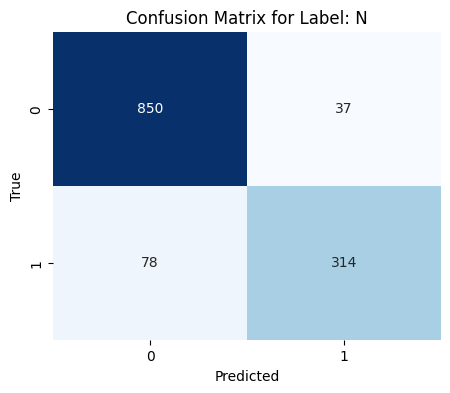

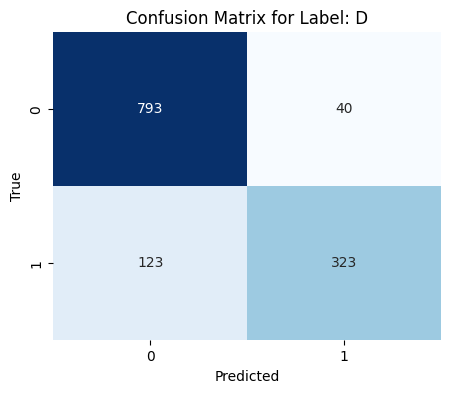

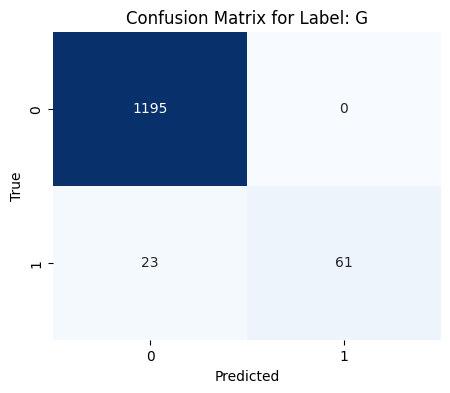

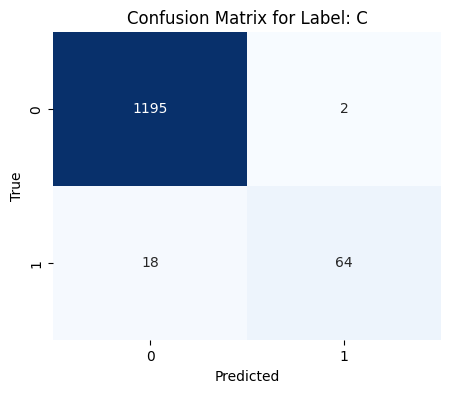

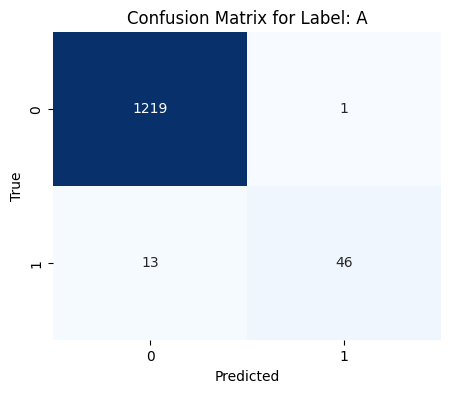

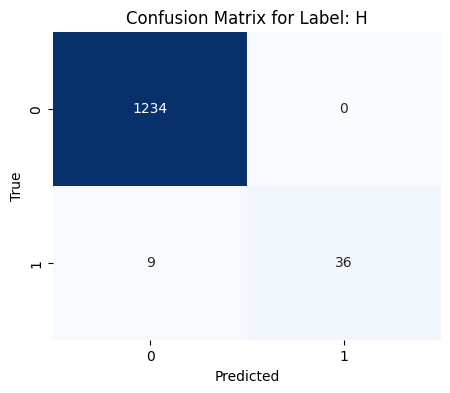

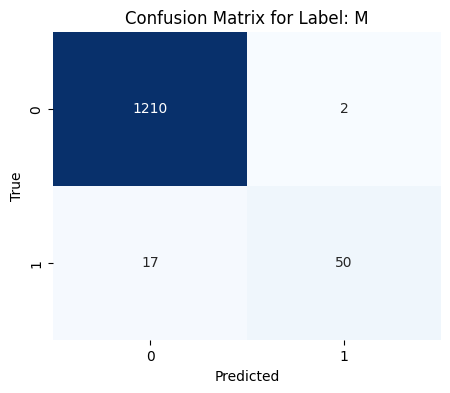

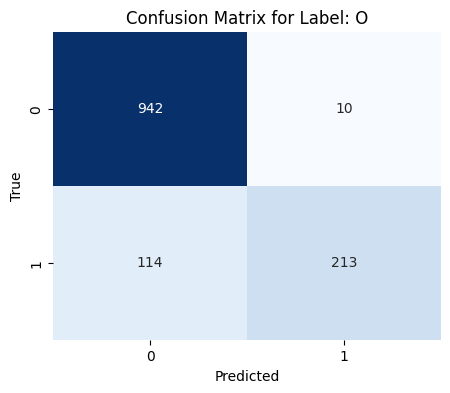

In [54]:
from sklearn.metrics import f1_score, precision_score, recall_score, multilabel_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate precision, recall, and F1-score for the validation set
val_precision = precision_score(y_val, y_val_pred_raw, average='micro')
val_recall = recall_score(y_val, y_val_pred_raw, average='micro')
val_f1 = f1_score(y_val, y_val_pred_raw, average='micro')

print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall: {val_recall:.4f}")
print(f"Validation F1-Score: {val_f1:.4f}")

# Generate a confusion matrix for each label
confusion_matrices = multilabel_confusion_matrix(y_val, y_val_pred_raw)
for i, label in enumerate(labels):
    plt.figure(figsize=(5, 4))
    sns.heatmap(confusion_matrices[i], annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix for Label: {label}")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


In [56]:
# Calculate training accuracy
training_accuracy = accuracy_score(y_train, y_train_pred_raw)
print(f"Training Accuracy: {training_accuracy:.4f}") 


Training Accuracy: 0.9720


In [59]:
# Save the trained model
model_filename = "xgboost_eye_disease_model_97.pkl"
joblib.dump(xgb_model, model_filename)
print(f"Model saved to {model_filename} with 97%  accuracy.")

Model saved to xgboost_eye_disease_model_97.pkl with 97%  accuracy.
